In [32]:
%pip install tensorflow keras 

Note: you may need to restart the kernel to use updated packages.


In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import tensorflow as tf
import random

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's random module
random.seed(42)


Only run the next cell if the data has not been split into training and validation

In [34]:
import os
import shutil
import random

# Set random seed
random.seed(42)

# Define paths
data_dir = 'data/'
train_dir = 'train/'
test_dir = 'test/'

# Clear train and test directories
shutil.rmtree(train_dir, ignore_errors=True)
shutil.rmtree(test_dir, ignore_errors=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get list of image filenames in each class folder
malignant_images = os.listdir(os.path.join(data_dir, 'malignant'))
normal_images = os.listdir(os.path.join(data_dir, 'normal'))

# Shuffle the filenames
random.shuffle(malignant_images)
random.shuffle(normal_images)

# Define the number of images for training and testing
train_count = 200
test_count = 50

# Split images into training and testing sets
malignant_train_images = malignant_images[:train_count]
malignant_test_images = malignant_images[train_count:train_count+test_count]

normal_train_images = normal_images[:train_count]
normal_test_images = normal_images[train_count:train_count+test_count]

# Copy images to train and test folders
for img in malignant_train_images:
    src = os.path.join(data_dir, 'malignant', img)
    dst_train = os.path.join(train_dir, 'malignant', img)
    os.makedirs(os.path.dirname(dst_train), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_train)

for img in malignant_test_images:
    src = os.path.join(data_dir, 'malignant', img)
    dst_test = os.path.join(test_dir, 'malignant', img)
    os.makedirs(os.path.dirname(dst_test), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_test)

for img in normal_train_images:
    src = os.path.join(data_dir, 'normal', img)
    dst_train = os.path.join(train_dir, 'normal', img)
    os.makedirs(os.path.dirname(dst_train), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_train)

for img in normal_test_images:
    src = os.path.join(data_dir, 'normal', img)
    dst_test = os.path.join(test_dir, 'normal', img)
    os.makedirs(os.path.dirname(dst_test), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_test)

print("Data copied successfully.")


Data copied successfully.


Setting up target size 

In [36]:

# Define directories
train_dir = 'train/'
test_dir = 'test/'

# Count number of files in train directory
train_malignant_count = len(os.listdir(os.path.join(train_dir, 'malignant')))
train_normal_count = len(os.listdir(os.path.join(train_dir, 'normal')))

# Count number of files in test directory
test_malignant_count = len(os.listdir(os.path.join(test_dir, 'malignant')))
test_normal_count = len(os.listdir(os.path.join(test_dir, 'normal')))

# Print counts
print("Train directory:")
print(f"Malignant: {train_malignant_count} images")
print(f"Normal: {train_normal_count} images")

print("\nTest directory:")
print(f"Malignant: {test_malignant_count} images")
print(f"Normal: {test_normal_count} images")


Train directory:
Malignant: 200 images
Normal: 200 images

Test directory:
Malignant: 50 images
Normal: 50 images


In [105]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Define image dimensions and other parameters
img_height = 128
img_width = 128
epochs = 10

# Create ImageDataGenerators for train and test data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=400,
    class_mode='binary',
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=100,
    class_mode='binary',
    shuffle=False)




Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [38]:
x_test, y_test = next(test_generator)

print(x_test.shape, y_test.shape)
num_samples = x_test.shape[0]
print("Number of samples in x_test:", num_samples)


(100, 128, 128, 3) (100,)
Number of samples in x_test: 100


In [39]:
import tensorflow as tf
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

class CustomKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, optimizer='adam', epochs=10, batch_size=32, verbose=1):
        self.build_fn = build_fn
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X, y):
        self.model = self.build_fn()
        self.model.compile(optimizer=self.optimizer,
                           loss='binary_crossentropy',
                           metrics=['accuracy'])
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype('int32')

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)


In [40]:

from sklearn.model_selection import GridSearchCV

# Define CNN model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

# Wrap Keras model in a scikit-learn compatible classifier
model = CustomKerasClassifier(build_fn=create_model, verbose=0)




In [91]:

# Define hyperparameters for grid search
param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [10, 15, 20],
    'optimizer': ['adam', 'sgd']
}

# Load the images
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

# Grid search
grid_search = GridSearchCV(estimator=CustomKerasClassifier(create_model), param_grid=param_grid, cv=5, return_train_score=True)
grid_search.fit(train_images, train_labels)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model
test_accuracy = best_model.score(test_images, test_labels)
print("Test Accuracy:", test_accuracy)


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.4794 - loss: 0.7634
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.7431 - loss: 0.5253
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - accuracy: 0.7995 - loss: 0.5162
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - accuracy: 0.8188 - loss: 0.5086
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - accuracy: 0.8200 - loss: 0.4993
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.8310 - loss: 0.4886
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - accuracy: 0.8830 - loss: 0.4755
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - accuracy: 0.8965 - loss: 0.4516
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - accuracy: 0.8212 - loss: 0.4997
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - accuracy: 0.8861 - loss: 0.4085
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 437ms/step - accuracy: 0.5153 - loss: 0.7848
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/step - accuracy: 0.8001 - loss: 0.5250
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.7713 - loss: 0.5209
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.7715 - loss: 0.5171
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.7825 - loss: 0.4541
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - accuracy: 0.7942 - loss: 0.3849
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step - accuracy: 0.8009 - loss: 0.3162
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 339ms/step - accuracy: 0.8548 - loss: 0.2892
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step - accuracy: 0.8925 - loss: 0.2271
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - accuracy: 0.9158 - loss: 0.1967
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 330ms/step - accuracy: 0.5147 - loss: 0.6623
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - accuracy: 0.7557 - loss: 0.5284
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.7545 - loss: 0.5270
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 536ms/step - accuracy: 0.7493 - loss: 0.5203
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 525ms/step - accuracy: 0.8308 - loss: 0.4568
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 433ms/step - accuracy: 0.8529 - loss: 0.3286
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 370ms/step - accuracy: 0.8563 - loss: 0.3354
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 351ms/step - accuracy: 0.8796 - loss: 0.2541
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.8756 - loss: 0.2462
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - accuracy: 0.8390 - loss: 0.2805
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 567ms/step - accuracy: 0.5091 - loss: 0.7174
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 571ms/step - accuracy: 0.7594 - loss: 0.5362
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 635ms/step - accuracy: 0.7868 - loss: 0.4741
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step - accuracy: 0.8301 - loss: 0.3588
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 372ms/step - accuracy: 0.8873 - loss: 0.2580
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 423ms/step - accuracy: 0.9305 - loss: 0.2007
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step - accuracy: 0.9528 - loss: 0.1517
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 423ms/step - accuracy: 0.9502 - loss: 0.1290
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 399ms/step - accuracy: 0.9629 - loss: 0.0900
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 351ms/step - accuracy: 0.9674 - loss: 0.0744
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 434ms/step - accuracy: 0.5414 - loss: 0.7420
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 354ms/step - accuracy: 0.8124 - loss: 0.5034
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.7974 - loss: 0.3946
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.8336 - loss: 0.3365
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.8520 - loss: 0.2796
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - accuracy: 0.9398 - loss: 0.1955
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 339ms/step - accuracy: 0.9498 - loss: 0.1305
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.9391 - loss: 0.1337
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.9731 - loss: 0.1006
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - accuracy: 0.9679 - loss: 0.0889
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.4916 - loss: 0.6934
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.7617 - loss: 0.6754
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step - accuracy: 0.7617 - loss: 0.6643
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - accuracy: 0.7617 - loss: 0.6551
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 366ms/step - accuracy: 0.7608 - loss: 0.6462
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 385ms/step - accuracy: 0.7504 - loss: 0.6370
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 354ms/step - accuracy: 0.7527 - loss: 0.6278
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - accuracy: 0.7473 - loss: 0.6186
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.7320 - loss: 0.6095
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 424ms/step - accuracy: 0.7299 - loss: 0.6006
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.5714 - loss: 0.6910
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - accuracy: 0.7676 - loss: 0.6817
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - accuracy: 0.7676 - loss: 0.6743
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - accuracy: 0.7676 - loss: 0.6674
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - accuracy: 0.7676 - loss: 0.6611
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - accuracy: 0.7676 - loss: 0.6550
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - accuracy: 0.7676 - loss: 0.6490
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - accuracy: 0.7676 - loss: 0.6427
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 296ms/step - accuracy: 0.7632 - loss: 0.6360
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - accuracy: 0.7573 - loss: 0.6288
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 321ms/step - accuracy: 0.4334 - loss: 0.6923
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - accuracy: 0.7392 - loss: 0.6729
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - accuracy: 0.7392 - loss: 0.6606
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 371ms/step - accuracy: 0.7386 - loss: 0.6493
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 373ms/step - accuracy: 0.7279 - loss: 0.6383
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - accuracy: 0.7237 - loss: 0.6276
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - accuracy: 0.7162 - loss: 0.6163
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 299ms/step - accuracy: 0.7046 - loss: 0.6053
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - accuracy: 0.7274 - loss: 0.5951
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 306ms/step - accuracy: 0.7513 - loss: 0.5856
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 282ms/step - accuracy: 0.5054 - loss: 0.6919
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 311ms/step - accuracy: 0.7430 - loss: 0.6803
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - accuracy: 0.7430 - loss: 0.6717
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 335ms/step - accuracy: 0.7430 - loss: 0.6643
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - accuracy: 0.7430 - loss: 0.6573
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - accuracy: 0.7430 - loss: 0.6500
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - accuracy: 0.7430 - loss: 0.6424
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - accuracy: 0.7199 - loss: 0.6342
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 306ms/step - accuracy: 0.7199 - loss: 0.6254
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - accuracy: 0.7049 - loss: 0.6160
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.4051 - loss: 0.6913
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - accuracy: 0.7376 - loss: 0.6775
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.7376 - loss: 0.6681
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 344ms/step - accuracy: 0.7376 - loss: 0.6594
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - accuracy: 0.7376 - loss: 0.6506
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - accuracy: 0.7284 - loss: 0.6414
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - accuracy: 0.7087 - loss: 0.6317
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - accuracy: 0.6934 - loss: 0.6220
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 354ms/step - accuracy: 0.6901 - loss: 0.6126
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - accuracy: 0.6706 - loss: 0.6035
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 306ms/step - accuracy: 0.4709 - loss: 0.7060
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - accuracy: 0.7815 - loss: 0.5229
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - accuracy: 0.8279 - loss: 0.5011
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - accuracy: 0.8201 - loss: 0.4758
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 344ms/step - accuracy: 0.8805 - loss: 0.3990
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - accuracy: 0.8986 - loss: 0.2467
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.9110 - loss: 0.1873
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 354ms/step - accuracy: 0.9277 - loss: 0.1691
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - accuracy: 0.9435 - loss: 0.1599
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.9094 - loss: 0.2353
Epoch 11/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - accuracy: 0.9480 - loss: 0.1237
Epoch 12/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 396ms/step - accuracy: 0.5146 - loss: 0.7240
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - accuracy: 0.7337 - loss: 0.5293
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - accuracy: 0.7693 - loss: 0.5084
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.7922 - loss: 0.4909
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 334ms/step - accuracy: 0.8608 - loss: 0.4338
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.8844 - loss: 0.3637
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 345ms/step - accuracy: 0.7686 - loss: 0.4345
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - accuracy: 0.8424 - loss: 0.2929
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step - accuracy: 0.8705 - loss: 0.2423
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.9109 - loss: 0.2068
Epoch 11/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.9160 - loss: 0.1602
Epoch 12/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/ste

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step - accuracy: 0.4945 - loss: 0.6451
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 442ms/step - accuracy: 0.7663 - loss: 0.5554
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 390ms/step - accuracy: 0.7571 - loss: 0.4886
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 375ms/step - accuracy: 0.7551 - loss: 0.3815
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 308ms/step - accuracy: 0.8706 - loss: 0.2907
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 352ms/step - accuracy: 0.8967 - loss: 0.2401
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.8680 - loss: 0.2638
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.9024 - loss: 0.2154
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - accuracy: 0.9288 - loss: 0.1894
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - accuracy: 0.9030 - loss: 0.1618
Epoch 11/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 423ms/step - accuracy: 0.9219 - loss: 0.1698
Epoch 12/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 347ms/ste

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 346ms/step - accuracy: 0.5163 - loss: 0.6598
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 436ms/step - accuracy: 0.7845 - loss: 0.5260
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - accuracy: 0.8739 - loss: 0.4836
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 344ms/step - accuracy: 0.8808 - loss: 0.4047
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.9348 - loss: 0.2740
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 451ms/step - accuracy: 0.9355 - loss: 0.1628
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 363ms/step - accuracy: 0.9537 - loss: 0.1083
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 351ms/step - accuracy: 0.9680 - loss: 0.0817
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 405ms/step - accuracy: 0.9515 - loss: 0.1564
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 515ms/step - accuracy: 0.9462 - loss: 0.1279
Epoch 11/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 682ms/step - accuracy: 0.9819 - loss: 0.0559
Epoch 12/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/ste

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 348ms/step - accuracy: 0.4874 - loss: 0.6630
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.8211 - loss: 0.5129
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - accuracy: 0.7932 - loss: 0.4630
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step - accuracy: 0.8253 - loss: 0.3713
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - accuracy: 0.7800 - loss: 0.3393
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - accuracy: 0.8773 - loss: 0.2511
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step - accuracy: 0.9140 - loss: 0.2294
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step - accuracy: 0.9191 - loss: 0.1790
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - accuracy: 0.9408 - loss: 0.1609
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - accuracy: 0.9434 - loss: 0.1251
Epoch 11/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - accuracy: 0.9533 - loss: 0.0974
Epoch 12/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - accuracy: 0.5187 - loss: 0.6858
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.7673 - loss: 0.6727
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.7673 - loss: 0.6628
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.7664 - loss: 0.6541
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.7630 - loss: 0.6450
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.7591 - loss: 0.6357
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.7538 - loss: 0.6263
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.7563 - loss: 0.6163
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.7530 - loss: 0.6065
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.7302 - loss: 0.5968
Epoch 11/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.7326 - loss: 0.5874
Epoch 12/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - accuracy: 0.5756 - loss: 0.6755
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.7676 - loss: 0.6573
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.7676 - loss: 0.6446
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.7643 - loss: 0.6327
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.7604 - loss: 0.6209
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.7507 - loss: 0.6091
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.7485 - loss: 0.5973
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.7486 - loss: 0.5867
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - accuracy: 0.7653 - loss: 0.5765
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.7690 - loss: 0.5674
Epoch 11/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.7683 - loss: 0.5584
Epoch 12/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.5849 - loss: 0.6801
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.7505 - loss: 0.6624
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.7478 - loss: 0.6492
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.7279 - loss: 0.6372
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - accuracy: 0.7220 - loss: 0.6256
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.7128 - loss: 0.6144
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.6914 - loss: 0.6037
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.7259 - loss: 0.5941
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.7321 - loss: 0.5854
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - accuracy: 0.7396 - loss: 0.5767
Epoch 11/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.7474 - loss: 0.5673
Epoch 12/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.6198 - loss: 0.6812
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.7416 - loss: 0.6660
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - accuracy: 0.7411 - loss: 0.6536
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - accuracy: 0.7226 - loss: 0.6420
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - accuracy: 0.7095 - loss: 0.6308
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - accuracy: 0.6983 - loss: 0.6194
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.6853 - loss: 0.6086
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.6766 - loss: 0.5984
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.7068 - loss: 0.5883
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.7315 - loss: 0.5784
Epoch 11/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - accuracy: 0.7379 - loss: 0.5687
Epoch 12/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.3006 - loss: 0.7026
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.6977 - loss: 0.6854
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - accuracy: 0.7119 - loss: 0.6747
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.7177 - loss: 0.6661
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.7177 - loss: 0.6583
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.7177 - loss: 0.6504
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.7177 - loss: 0.6424
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.7085 - loss: 0.6339
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - accuracy: 0.7028 - loss: 0.6251
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.6947 - loss: 0.6161
Epoch 11/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.6860 - loss: 0.6071
Epoch 12/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.5056 - loss: 0.8141
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 0.8039 - loss: 0.5260
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.7794 - loss: 0.5267
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.7864 - loss: 0.5139
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.7995 - loss: 0.5006
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.8028 - loss: 0.4902
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.8374 - loss: 0.4592
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.8282 - loss: 0.4371
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.8108 - loss: 0.3836
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.8812 - loss: 0.2595
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.8993 - loss: 0.1779
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.4785 - loss: 0.7016
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.7759 - loss: 0.5230
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.7801 - loss: 0.4963
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.8139 - loss: 0.4753
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.7610 - loss: 0.4367
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.8241 - loss: 0.3314
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - accuracy: 0.8350 - loss: 0.2712
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.8937 - loss: 0.2153
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.9049 - loss: 0.1901
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - accuracy: 0.9337 - loss: 0.1563
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.9257 - loss: 0.1754
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.4964 - loss: 0.6854
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.7314 - loss: 0.5409
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.7509 - loss: 0.5098
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.7629 - loss: 0.4463
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.8005 - loss: 0.3686
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.8470 - loss: 0.3032
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.8772 - loss: 0.2692
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - accuracy: 0.8761 - loss: 0.2676
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - accuracy: 0.8670 - loss: 0.2565
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - accuracy: 0.9094 - loss: 0.1946
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - accuracy: 0.9207 - loss: 0.1686
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.5001 - loss: 0.7094
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.8006 - loss: 0.5471
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.7672 - loss: 0.5231
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - accuracy: 0.8532 - loss: 0.4859
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.8492 - loss: 0.3975
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - accuracy: 0.8815 - loss: 0.2679
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.9286 - loss: 0.1622
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - accuracy: 0.9282 - loss: 0.1448
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - accuracy: 0.9416 - loss: 0.1327
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.9749 - loss: 0.0691
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - accuracy: 0.9724 - loss: 0.0699
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - accuracy

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.5042 - loss: 0.6986
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.7612 - loss: 0.5171
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - accuracy: 0.8154 - loss: 0.4890
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.8086 - loss: 0.4416
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.8771 - loss: 0.3383
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - accuracy: 0.8729 - loss: 0.3214
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - accuracy: 0.8933 - loss: 0.2376
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.9418 - loss: 0.1527
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.9221 - loss: 0.1827
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.9661 - loss: 0.1029
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.9557 - loss: 0.1024
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 294ms/step - accuracy: 0.5401 - loss: 0.6851
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - accuracy: 0.7529 - loss: 0.6679
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.7587 - loss: 0.6558
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - accuracy: 0.7560 - loss: 0.6446
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.7529 - loss: 0.6331
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.7443 - loss: 0.6216
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.7428 - loss: 0.6101
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.7279 - loss: 0.5993
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.7369 - loss: 0.5893
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.7411 - loss: 0.5798
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.7512 - loss: 0.5706
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.5440 - loss: 0.6908
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.7618 - loss: 0.6709
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.7676 - loss: 0.6575
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - accuracy: 0.7670 - loss: 0.6461
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - accuracy: 0.7638 - loss: 0.6350
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.7613 - loss: 0.6241
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.7361 - loss: 0.6134
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.7409 - loss: 0.6034
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.7321 - loss: 0.5944
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.7307 - loss: 0.5855
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.7366 - loss: 0.5772
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.3584 - loss: 0.6945
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.7199 - loss: 0.6799
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.7505 - loss: 0.6695
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.7505 - loss: 0.6603
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - accuracy: 0.7418 - loss: 0.6520
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.7413 - loss: 0.6437
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.7285 - loss: 0.6350
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.7111 - loss: 0.6260
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.6822 - loss: 0.6167
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.6944 - loss: 0.6076
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - accuracy: 0.7158 - loss: 0.5989
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.5829 - loss: 0.6882
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.7264 - loss: 0.6704
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.7258 - loss: 0.6580
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - accuracy: 0.7316 - loss: 0.6456
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - accuracy: 0.7262 - loss: 0.6325
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.6985 - loss: 0.6190
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - accuracy: 0.7032 - loss: 0.6065
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - accuracy: 0.7201 - loss: 0.5948
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.7227 - loss: 0.5840
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.7383 - loss: 0.5739
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.7469 - loss: 0.5640
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.4322 - loss: 0.6921
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.7290 - loss: 0.6817
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - accuracy: 0.7376 - loss: 0.6733
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.7376 - loss: 0.6658
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.7376 - loss: 0.6588
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.7263 - loss: 0.6515
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.7263 - loss: 0.6437
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.7263 - loss: 0.6356
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.7171 - loss: 0.6273
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 0.7059 - loss: 0.6186
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.6964 - loss: 0.6098
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 584ms/step - accuracy: 0.4649 - loss: 0.7451
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - accuracy: 0.5387 - loss: 0.5693
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - accuracy: 0.8280 - loss: 0.5214
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - accuracy: 0.8204 - loss: 0.5073
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.8331 - loss: 0.5002
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.8324 - loss: 0.4910
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 487ms/step - accuracy: 0.8727 - loss: 0.4752
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - accuracy: 0.8988 - loss: 0.4443
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 489ms/step - accuracy: 0.9127 - loss: 0.3941
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step - accuracy: 0.9176 - loss: 0.3323
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 468ms/step - accuracy: 0.4727 - loss: 0.7490
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - accuracy: 0.5591 - loss: 0.5786
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 0.8068 - loss: 0.5197
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 0.8360 - loss: 0.5012
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.8377 - loss: 0.4852
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - accuracy: 0.8719 - loss: 0.4575
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.8802 - loss: 0.4200
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 0.9097 - loss: 0.3488
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - accuracy: 0.9190 - loss: 0.2747
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 468ms/step - accuracy: 0.9020 - loss: 0.2079
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 442ms/step - accuracy: 0.5235 - loss: 0.7767
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.5707 - loss: 0.5884
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.7644 - loss: 0.5326
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.7526 - loss: 0.5227
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - accuracy: 0.7526 - loss: 0.5210
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - accuracy: 0.7639 - loss: 0.5186
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - accuracy: 0.7738 - loss: 0.5157
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.7860 - loss: 0.5120
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - accuracy: 0.8017 - loss: 0.5054
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.7890 - loss: 0.4999
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 426ms/step - accuracy: 0.4167 - loss: 0.6837
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - accuracy: 0.6020 - loss: 0.5523
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 0.7847 - loss: 0.5093
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - accuracy: 0.8103 - loss: 0.4854
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - accuracy: 0.8491 - loss: 0.4432
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step - accuracy: 0.8318 - loss: 0.3807
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - accuracy: 0.8983 - loss: 0.2849
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 0.9233 - loss: 0.2168
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 0.9270 - loss: 0.1821
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - accuracy: 0.9303 - loss: 0.1428
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 409ms/step - accuracy: 0.4376 - loss: 0.6778
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.7292 - loss: 0.5527
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 0.7961 - loss: 0.5036
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.7934 - loss: 0.4861
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.7862 - loss: 0.4763
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.8597 - loss: 0.4392
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - accuracy: 0.8368 - loss: 0.3494
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.7997 - loss: 0.3627
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.8648 - loss: 0.2720
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - accuracy: 0.9000 - loss: 0.2274
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 445ms/step - accuracy: 0.4309 - loss: 0.6992
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 427ms/step - accuracy: 0.5554 - loss: 0.6853
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.7536 - loss: 0.6778
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 0.7553 - loss: 0.6719
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step - accuracy: 0.7553 - loss: 0.6663
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 424ms/step - accuracy: 0.7553 - loss: 0.6604
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step - accuracy: 0.7515 - loss: 0.6546
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.7489 - loss: 0.6488
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 417ms/step - accuracy: 0.7479 - loss: 0.6429
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 413ms/step - accuracy: 0.7430 - loss: 0.6369
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - accuracy: 0.3506 - loss: 0.6972
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step - accuracy: 0.4995 - loss: 0.6889
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.6114 - loss: 0.6831
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 427ms/step - accuracy: 0.7498 - loss: 0.6785
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - accuracy: 0.7536 - loss: 0.6747
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 414ms/step - accuracy: 0.7564 - loss: 0.6710
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - accuracy: 0.7564 - loss: 0.6674
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.7564 - loss: 0.6639
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.7564 - loss: 0.6605
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - accuracy: 0.7564 - loss: 0.6571
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 423ms/step - accuracy: 0.5480 - loss: 0.6781
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - accuracy: 0.7326 - loss: 0.6682
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - accuracy: 0.7326 - loss: 0.6598
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step - accuracy: 0.7326 - loss: 0.6525
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step - accuracy: 0.7326 - loss: 0.6454
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - accuracy: 0.7236 - loss: 0.6385
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - accuracy: 0.7211 - loss: 0.6317
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step - accuracy: 0.7266 - loss: 0.6250
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step - accuracy: 0.7203 - loss: 0.6185
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - accuracy: 0.7130 - loss: 0.6121
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 432ms/step - accuracy: 0.5403 - loss: 0.6806
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step - accuracy: 0.7454 - loss: 0.6687
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step - accuracy: 0.7454 - loss: 0.6607
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - accuracy: 0.7454 - loss: 0.6536
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - accuracy: 0.7418 - loss: 0.6467
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 414ms/step - accuracy: 0.7343 - loss: 0.6398
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - accuracy: 0.7343 - loss: 0.6328
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - accuracy: 0.7343 - loss: 0.6259
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - accuracy: 0.7253 - loss: 0.6191
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step - accuracy: 0.7226 - loss: 0.6126
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step - accuracy: 0.3976 - loss: 0.6897
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.7311 - loss: 0.6759
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - accuracy: 0.7376 - loss: 0.6685
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.7376 - loss: 0.6626
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 419ms/step - accuracy: 0.7376 - loss: 0.6569
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step - accuracy: 0.7311 - loss: 0.6512
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - accuracy: 0.7311 - loss: 0.6458
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step - accuracy: 0.7247 - loss: 0.6404
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - accuracy: 0.7221 - loss: 0.6349
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 476ms/step - accuracy: 0.7172 - loss: 0.6294
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 487ms/step - accuracy: 0.4147 - loss: 0.7580
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step - accuracy: 0.5417 - loss: 0.5868
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - accuracy: 0.8243 - loss: 0.5215
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.8205 - loss: 0.5082
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 0.8414 - loss: 0.5007
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.8339 - loss: 0.4918
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - accuracy: 0.8959 - loss: 0.4694
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - accuracy: 0.8879 - loss: 0.4418
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - accuracy: 0.9206 - loss: 0.3986
Epoch 10/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step - accuracy: 0.9411 - loss: 0.3499
Epoch 11/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - accuracy: 0.9263 - loss: 0.3158
Epoch 12/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.9138 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 433ms/step - accuracy: 0.4454 - loss: 0.6869
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - accuracy: 0.6270 - loss: 0.5595
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.7957 - loss: 0.5208
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 481ms/step - accuracy: 0.7840 - loss: 0.5083
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 503ms/step - accuracy: 0.8400 - loss: 0.4979
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 476ms/step - accuracy: 0.8191 - loss: 0.4855
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.8565 - loss: 0.4608
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 0.8679 - loss: 0.4116
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.9145 - loss: 0.3707
Epoch 10/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - accuracy: 0.9094 - loss: 0.3019
Epoch 11/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - accuracy: 0.9237 - loss: 0.1905
Epoch 12/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - accuracy: 0.8972 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 412ms/step - accuracy: 0.4348 - loss: 0.8161
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 486ms/step - accuracy: 0.5693 - loss: 0.5994
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 469ms/step - accuracy: 0.7534 - loss: 0.5368
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step - accuracy: 0.7655 - loss: 0.5226
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - accuracy: 0.7770 - loss: 0.5200
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - accuracy: 0.7665 - loss: 0.5179
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 477ms/step - accuracy: 0.7595 - loss: 0.5180
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 481ms/step - accuracy: 0.7900 - loss: 0.5136
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step - accuracy: 0.8501 - loss: 0.5042
Epoch 10/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - accuracy: 0.8292 - loss: 0.4923
Epoch 11/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - accuracy: 0.8973 - loss: 0.4774
Epoch 12/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step - accuracy: 0.9102 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 447ms/step - accuracy: 0.4457 - loss: 0.7848
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step - accuracy: 0.6171 - loss: 0.5865
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - accuracy: 0.7473 - loss: 0.5219
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - accuracy: 0.7826 - loss: 0.5080
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - accuracy: 0.8092 - loss: 0.4929
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step - accuracy: 0.8645 - loss: 0.4714
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 422ms/step - accuracy: 0.8743 - loss: 0.4423
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - accuracy: 0.9243 - loss: 0.3770
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - accuracy: 0.7853 - loss: 0.5401
Epoch 10/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step - accuracy: 0.8767 - loss: 0.4230
Epoch 11/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step - accuracy: 0.9002 - loss: 0.3376
Epoch 12/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.9391 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 386ms/step - accuracy: 0.5214 - loss: 0.7045
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.5855 - loss: 0.5647
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - accuracy: 0.7676 - loss: 0.5108
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - accuracy: 0.8066 - loss: 0.4904
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - accuracy: 0.8235 - loss: 0.4596
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step - accuracy: 0.8115 - loss: 0.4173
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - accuracy: 0.8738 - loss: 0.3168
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - accuracy: 0.8950 - loss: 0.2527
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - accuracy: 0.8714 - loss: 0.2519
Epoch 10/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - accuracy: 0.9207 - loss: 0.1857
Epoch 11/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - accuracy: 0.9447 - loss: 0.1489
Epoch 12/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 0.9486 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step - accuracy: 0.5320 - loss: 0.6877
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step - accuracy: 0.5947 - loss: 0.6763
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - accuracy: 0.7564 - loss: 0.6682
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - accuracy: 0.7564 - loss: 0.6614
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - accuracy: 0.7564 - loss: 0.6552
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - accuracy: 0.7564 - loss: 0.6488
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - accuracy: 0.7536 - loss: 0.6427
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step - accuracy: 0.7536 - loss: 0.6366
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - accuracy: 0.7462 - loss: 0.6305
Epoch 10/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 414ms/step - accuracy: 0.7430 - loss: 0.6245
Epoch 11/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - accuracy: 0.7413 - loss: 0.6186
Epoch 12/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - accuracy: 0.7441 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 444ms/step - accuracy: 0.3230 - loss: 0.6974
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 427ms/step - accuracy: 0.5536 - loss: 0.6895
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step - accuracy: 0.7450 - loss: 0.6835
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 511ms/step - accuracy: 0.7461 - loss: 0.6785
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - accuracy: 0.7461 - loss: 0.6743
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.7461 - loss: 0.6704
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step - accuracy: 0.7461 - loss: 0.6666
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 476ms/step - accuracy: 0.7525 - loss: 0.6628
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - accuracy: 0.7525 - loss: 0.6591
Epoch 10/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 424ms/step - accuracy: 0.7525 - loss: 0.6555
Epoch 11/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - accuracy: 0.7525 - loss: 0.6519
Epoch 12/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - accuracy: 0.7525 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step - accuracy: 0.3671 - loss: 0.6911
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step - accuracy: 0.6188 - loss: 0.6816
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - accuracy: 0.7417 - loss: 0.6747
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/step - accuracy: 0.7417 - loss: 0.6690
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step - accuracy: 0.7417 - loss: 0.6638
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.7417 - loss: 0.6585
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.7391 - loss: 0.6533
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 0.7391 - loss: 0.6484
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - accuracy: 0.7262 - loss: 0.6434
Epoch 10/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - accuracy: 0.7226 - loss: 0.6384
Epoch 11/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step - accuracy: 0.7226 - loss: 0.6333
Epoch 12/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - accuracy: 0.7161 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - accuracy: 0.5794 - loss: 0.6894
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step - accuracy: 0.7330 - loss: 0.6795
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 0.7437 - loss: 0.6724
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 427ms/step - accuracy: 0.7437 - loss: 0.6668
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - accuracy: 0.7437 - loss: 0.6619
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - accuracy: 0.7437 - loss: 0.6571
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - accuracy: 0.7437 - loss: 0.6524
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 468ms/step - accuracy: 0.7437 - loss: 0.6476
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - accuracy: 0.7437 - loss: 0.6427
Epoch 10/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - accuracy: 0.7437 - loss: 0.6377
Epoch 11/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - accuracy: 0.7372 - loss: 0.6327
Epoch 12/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step - accuracy: 0.7372 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 473ms/step - accuracy: 0.3398 - loss: 0.6968
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step - accuracy: 0.4960 - loss: 0.6848
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - accuracy: 0.7337 - loss: 0.6771
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - accuracy: 0.7376 - loss: 0.6712
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step - accuracy: 0.7376 - loss: 0.6657
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - accuracy: 0.7311 - loss: 0.6605
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - accuracy: 0.7311 - loss: 0.6552
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - accuracy: 0.7311 - loss: 0.6500
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 0.7286 - loss: 0.6447
Epoch 10/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.7286 - loss: 0.6395
Epoch 11/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step - accuracy: 0.7221 - loss: 0.6342
Epoch 12/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - accuracy: 0.7204 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 422ms/step - accuracy: 0.4668 - loss: 0.7533
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 0.5290 - loss: 0.5877
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - accuracy: 0.7553 - loss: 0.5276
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.8030 - loss: 0.5135
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.7842 - loss: 0.5083
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 0.8512 - loss: 0.5022
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - accuracy: 0.8202 - loss: 0.4934
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - accuracy: 0.8900 - loss: 0.4821
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - accuracy: 0.9036 - loss: 0.4632
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - accuracy: 0.8998 - loss: 0.4287
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.9109 - loss: 0.3764
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - accuracy: 0.9327 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 396ms/step - accuracy: 0.4457 - loss: 0.7421
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 0.5622 - loss: 0.5929
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - accuracy: 0.8013 - loss: 0.5299
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 492ms/step - accuracy: 0.7970 - loss: 0.5104
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - accuracy: 0.7880 - loss: 0.5037
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - accuracy: 0.8261 - loss: 0.4887
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step - accuracy: 0.8388 - loss: 0.4635
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - accuracy: 0.8775 - loss: 0.4249
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.8736 - loss: 0.3571
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.9244 - loss: 0.2807
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.8704 - loss: 0.2635
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9141 - loss: 0.2100


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 466ms/step - accuracy: 0.4567 - loss: 0.9249
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - accuracy: 0.5643 - loss: 0.6074
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - accuracy: 0.7609 - loss: 0.5361
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - accuracy: 0.7575 - loss: 0.5231
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - accuracy: 0.7661 - loss: 0.5197
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - accuracy: 0.7665 - loss: 0.5158
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - accuracy: 0.7582 - loss: 0.5127
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - accuracy: 0.8076 - loss: 0.4986
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - accuracy: 0.8227 - loss: 0.4792
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 0.8220 - loss: 0.4680
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step - accuracy: 0.8191 - loss: 0.4687
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - accuracy: 0.8801 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 445ms/step - accuracy: 0.4353 - loss: 0.6855
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - accuracy: 0.7480 - loss: 0.5686
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - accuracy: 0.7973 - loss: 0.5200
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - accuracy: 0.7750 - loss: 0.5067
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.8410 - loss: 0.4929
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - accuracy: 0.8505 - loss: 0.4734
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - accuracy: 0.8498 - loss: 0.4379
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step - accuracy: 0.9104 - loss: 0.3697
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.8697 - loss: 0.3327
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - accuracy: 0.9137 - loss: 0.2407
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - accuracy: 0.9197 - loss: 0.1775
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.9507 - loss: 0.1428


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 445ms/step - accuracy: 0.5203 - loss: 0.7966
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step - accuracy: 0.6188 - loss: 0.5864
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 468ms/step - accuracy: 0.7397 - loss: 0.5206
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - accuracy: 0.8528 - loss: 0.4989
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - accuracy: 0.8695 - loss: 0.4817
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 492ms/step - accuracy: 0.8980 - loss: 0.4567
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - accuracy: 0.8743 - loss: 0.4298
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.8969 - loss: 0.3892
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.8569 - loss: 0.3156
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - accuracy: 0.8971 - loss: 0.2358
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 0.9302 - loss: 0.1770
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - accuracy: 0.9457 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - accuracy: 0.5637 - loss: 0.6871
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.7564 - loss: 0.6765
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 0.7564 - loss: 0.6690
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - accuracy: 0.7564 - loss: 0.6623
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.7564 - loss: 0.6559
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 480ms/step - accuracy: 0.7553 - loss: 0.6495
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - accuracy: 0.7553 - loss: 0.6431
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - accuracy: 0.7489 - loss: 0.6365
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.7468 - loss: 0.6300
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 0.7436 - loss: 0.6237
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - accuracy: 0.7458 - loss: 0.6174
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 418ms/step - accuracy: 0.7391 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 466ms/step - accuracy: 0.5390 - loss: 0.6830
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - accuracy: 0.7564 - loss: 0.6724
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - accuracy: 0.7564 - loss: 0.6650
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step - accuracy: 0.7564 - loss: 0.6588
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 416ms/step - accuracy: 0.7564 - loss: 0.6529
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 482ms/step - accuracy: 0.7564 - loss: 0.6468
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - accuracy: 0.7564 - loss: 0.6405
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - accuracy: 0.7564 - loss: 0.6341
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.7500 - loss: 0.6275
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - accuracy: 0.7464 - loss: 0.6208
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - accuracy: 0.7440 - loss: 0.6142
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step - accuracy: 0.7394 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 459ms/step - accuracy: 0.2487 - loss: 0.7097
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - accuracy: 0.4170 - loss: 0.6887
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - accuracy: 0.7206 - loss: 0.6790
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - accuracy: 0.7245 - loss: 0.6717
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.7245 - loss: 0.6654
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - accuracy: 0.7245 - loss: 0.6594
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 0.7155 - loss: 0.6534
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.7209 - loss: 0.6474
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 417ms/step - accuracy: 0.7247 - loss: 0.6415
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 0.7184 - loss: 0.6355
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step - accuracy: 0.7203 - loss: 0.6293
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 419ms/step - accuracy: 0.6970 - loss: 0.6232


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 447ms/step - accuracy: 0.4032 - loss: 0.6936
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 413ms/step - accuracy: 0.7454 - loss: 0.6781
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step - accuracy: 0.7454 - loss: 0.6689
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - accuracy: 0.7454 - loss: 0.6619
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step - accuracy: 0.7454 - loss: 0.6556
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - accuracy: 0.7454 - loss: 0.6494
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - accuracy: 0.7454 - loss: 0.6432
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - accuracy: 0.7454 - loss: 0.6372
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 487ms/step - accuracy: 0.7353 - loss: 0.6310
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - accuracy: 0.7353 - loss: 0.6249
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - accuracy: 0.7214 - loss: 0.6187
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.7291 - loss: 0.6125


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step - accuracy: 0.5378 - loss: 0.6799
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step - accuracy: 0.7376 - loss: 0.6710
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.7376 - loss: 0.6646
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - accuracy: 0.7376 - loss: 0.6589
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.7376 - loss: 0.6533
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - accuracy: 0.7376 - loss: 0.6475
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - accuracy: 0.7376 - loss: 0.6418
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - accuracy: 0.7376 - loss: 0.6360
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step - accuracy: 0.7311 - loss: 0.6301
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - accuracy: 0.7286 - loss: 0.6242
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.7307 - loss: 0.6182
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step - accuracy: 0.7237 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 718ms/step - accuracy: 0.4041 - loss: 0.7351
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 637ms/step - accuracy: 0.4959 - loss: 0.6218
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 721ms/step - accuracy: 0.5600 - loss: 0.5823
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 657ms/step - accuracy: 0.8064 - loss: 0.5185
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 647ms/step - accuracy: 0.7744 - loss: 0.5093
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 657ms/step - accuracy: 0.8051 - loss: 0.4977
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 655ms/step - accuracy: 0.8102 - loss: 0.4919
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 624ms/step - accuracy: 0.8186 - loss: 0.4861
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 638ms/step - accuracy: 0.8137 - loss: 0.4743
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 693ms/step - accuracy: 0.8635 - loss: 0.4646
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 647ms/step - accuracy: 0.3959 - loss: 0.8129
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 672ms/step - accuracy: 0.4973 - loss: 0.6485
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 766ms/step - accuracy: 0.5834 - loss: 0.5678
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 683ms/step - accuracy: 0.5828 - loss: 0.5472
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 901ms/step - accuracy: 0.7822 - loss: 0.5153
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 668ms/step - accuracy: 0.7695 - loss: 0.5070
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 680ms/step - accuracy: 0.7781 - loss: 0.5011
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 635ms/step - accuracy: 0.7867 - loss: 0.4955
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 690ms/step - accuracy: 0.8100 - loss: 0.4859
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 645ms/step - accuracy: 0.8281 - loss: 0.4768
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 663ms/step - accuracy: 0.3992 - loss: 0.9169
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 681ms/step - accuracy: 0.4961 - loss: 0.6364
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 709ms/step - accuracy: 0.7037 - loss: 0.5633
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 823ms/step - accuracy: 0.7543 - loss: 0.5291
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 731ms/step - accuracy: 0.7664 - loss: 0.5158
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 685ms/step - accuracy: 0.7742 - loss: 0.5127
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 736ms/step - accuracy: 0.7754 - loss: 0.5066
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 642ms/step - accuracy: 0.7619 - loss: 0.5074
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 676ms/step - accuracy: 0.7619 - loss: 0.5030
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 686ms/step - accuracy: 0.7674 - loss: 0.4972
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 726ms/step - accuracy: 0.3613 - loss: 0.8328
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 648ms/step - accuracy: 0.5672 - loss: 0.6213
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 741ms/step - accuracy: 0.5195 - loss: 0.5559
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 675ms/step - accuracy: 0.7721 - loss: 0.5234
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 616ms/step - accuracy: 0.7939 - loss: 0.5112
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 653ms/step - accuracy: 0.8070 - loss: 0.5034
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 665ms/step - accuracy: 0.8211 - loss: 0.4963
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 622ms/step - accuracy: 0.7738 - loss: 0.4866
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 708ms/step - accuracy: 0.8535 - loss: 0.4804
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 653ms/step - accuracy: 0.8549 - loss: 0.4714
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 668ms/step - accuracy: 0.3816 - loss: 0.7243
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 693ms/step - accuracy: 0.5029 - loss: 0.6259
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 703ms/step - accuracy: 0.6266 - loss: 0.5508
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 659ms/step - accuracy: 0.7162 - loss: 0.5226
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7588 - loss: 0.5121
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 864ms/step - accuracy: 0.7799 - loss: 0.5065
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 832ms/step - accuracy: 0.7871 - loss: 0.5027
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 689ms/step - accuracy: 0.7998 - loss: 0.4992
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 691ms/step - accuracy: 0.8062 - loss: 0.4973
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 695ms/step - accuracy: 0.7680 - loss: 0.4909
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step - accuracy: 0.2736 - loss: 0.7038
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 660ms/step - accuracy: 0.4607 - loss: 0.6850
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 678ms/step - accuracy: 0.4648 - loss: 0.6752
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 873ms/step - accuracy: 0.5475 - loss: 0.6685
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 805ms/step - accuracy: 0.7387 - loss: 0.6632
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 868ms/step - accuracy: 0.7432 - loss: 0.6585
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 775ms/step - accuracy: 0.7432 - loss: 0.6539
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 795ms/step - accuracy: 0.7432 - loss: 0.6495
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 724ms/step - accuracy: 0.7432 - loss: 0.6452
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 730ms/step - accuracy: 0.7432 - loss: 0.6410
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 749ms/step - accuracy: 0.3686 - loss: 0.6923
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 777ms/step - accuracy: 0.5207 - loss: 0.6859
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 959ms/step - accuracy: 0.5514 - loss: 0.6806
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 980ms/step - accuracy: 0.7352 - loss: 0.6760
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 987ms/step - accuracy: 0.7352 - loss: 0.6718
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 922ms/step - accuracy: 0.7396 - loss: 0.6679
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 905ms/step - accuracy: 0.7396 - loss: 0.6643
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 856ms/step - accuracy: 0.7396 - loss: 0.6610
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 768ms/step - accuracy: 0.7422 - loss: 0.6577
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 825ms/step - accuracy: 0.7422 - loss: 0.6546
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 692ms/step - accuracy: 0.2986 - loss: 0.6996
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 864ms/step - accuracy: 0.4459 - loss: 0.6939
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 678ms/step - accuracy: 0.6838 - loss: 0.6890
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 749ms/step - accuracy: 0.7074 - loss: 0.6847
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 834ms/step - accuracy: 0.7215 - loss: 0.6809
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 784ms/step - accuracy: 0.7311 - loss: 0.6775
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 725ms/step - accuracy: 0.7311 - loss: 0.6744
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 667ms/step - accuracy: 0.7311 - loss: 0.6714
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 708ms/step - accuracy: 0.7336 - loss: 0.6685
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 684ms/step - accuracy: 0.7336 - loss: 0.6656
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 676ms/step - accuracy: 0.2994 - loss: 0.6995
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 766ms/step - accuracy: 0.4467 - loss: 0.6891
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 712ms/step - accuracy: 0.5699 - loss: 0.6821
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 729ms/step - accuracy: 0.7227 - loss: 0.6768
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 737ms/step - accuracy: 0.7227 - loss: 0.6722
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 767ms/step - accuracy: 0.7271 - loss: 0.6680
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 804ms/step - accuracy: 0.7297 - loss: 0.6641
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 734ms/step - accuracy: 0.7297 - loss: 0.6605
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 728ms/step - accuracy: 0.7297 - loss: 0.6569
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 706ms/step - accuracy: 0.7297 - loss: 0.6533
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 685ms/step - accuracy: 0.3268 - loss: 0.6984
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 819ms/step - accuracy: 0.5594 - loss: 0.6829
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 755ms/step - accuracy: 0.7104 - loss: 0.6741
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 873ms/step - accuracy: 0.7244 - loss: 0.6679
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 775ms/step - accuracy: 0.7244 - loss: 0.6628
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 803ms/step - accuracy: 0.7219 - loss: 0.6579
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 713ms/step - accuracy: 0.7219 - loss: 0.6533
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 802ms/step - accuracy: 0.7174 - loss: 0.6489
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 713ms/step - accuracy: 0.7174 - loss: 0.6445
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 716ms/step - accuracy: 0.7148 - loss: 0.6402
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 729ms/step - accuracy: 0.4729 - loss: 0.9130
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 728ms/step - accuracy: 0.6797 - loss: 0.6170
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 862ms/step - accuracy: 0.5693 - loss: 0.6574
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 803ms/step - accuracy: 0.7984 - loss: 0.5172
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 708ms/step - accuracy: 0.7533 - loss: 0.5150
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 675ms/step - accuracy: 0.7955 - loss: 0.5028
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step - accuracy: 0.7955 - loss: 0.4967
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 730ms/step - accuracy: 0.8232 - loss: 0.5014
Epoch 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 734ms/step - accuracy: 0.8160 - loss: 0.4875
Epoch 10/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 696ms/step - accuracy: 0.7971 - loss: 0.4857
Epoch 11/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 674ms/step - accuracy: 0.8047 - loss: 0.4796
Epoch 12/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 711ms/step - accuracy: 0.8313 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 713ms/step - accuracy: 0.3824 - loss: 0.8212
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 661ms/step - accuracy: 0.6699 - loss: 0.6404
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 663ms/step - accuracy: 0.7486 - loss: 0.6236
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 696ms/step - accuracy: 0.7576 - loss: 0.5387
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 683ms/step - accuracy: 0.7771 - loss: 0.5124
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 673ms/step - accuracy: 0.7746 - loss: 0.5049
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 666ms/step - accuracy: 0.7867 - loss: 0.4973
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 720ms/step - accuracy: 0.7842 - loss: 0.4936
Epoch 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 747ms/step - accuracy: 0.7822 - loss: 0.4927
Epoch 10/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 811ms/step - accuracy: 0.7867 - loss: 0.4884
Epoch 11/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 719ms/step - accuracy: 0.7883 - loss: 0.4851
Epoch 12/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 916ms/step - accuracy: 0.7928 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 679ms/step - accuracy: 0.4576 - loss: 0.8552
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 746ms/step - accuracy: 0.5037 - loss: 0.6317
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 699ms/step - accuracy: 0.7309 - loss: 0.5467
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 858ms/step - accuracy: 0.7098 - loss: 0.5277
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 888ms/step - accuracy: 0.7578 - loss: 0.5172
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 756ms/step - accuracy: 0.7568 - loss: 0.5093
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 701ms/step - accuracy: 0.7543 - loss: 0.5098
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 706ms/step - accuracy: 0.7578 - loss: 0.5057
Epoch 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 719ms/step - accuracy: 0.7594 - loss: 0.5058
Epoch 10/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 696ms/step - accuracy: 0.7594 - loss: 0.5021
Epoch 11/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 727ms/step - accuracy: 0.7604 - loss: 0.4979
Epoch 12/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 789ms/step - accuracy: 0.7604 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 736ms/step - accuracy: 0.3703 - loss: 0.7738
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 676ms/step - accuracy: 0.6176 - loss: 0.6276
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 726ms/step - accuracy: 0.7502 - loss: 0.5556
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 694ms/step - accuracy: 0.7570 - loss: 0.5215
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 651ms/step - accuracy: 0.7678 - loss: 0.5092
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 666ms/step - accuracy: 0.7793 - loss: 0.5034
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 735ms/step - accuracy: 0.7805 - loss: 0.4972
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 677ms/step - accuracy: 0.7627 - loss: 0.4939
Epoch 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 858ms/step - accuracy: 0.7881 - loss: 0.4837
Epoch 10/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 715ms/step - accuracy: 0.7912 - loss: 0.4752
Epoch 11/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 731ms/step - accuracy: 0.8199 - loss: 0.4634
Epoch 12/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 661ms/step - accuracy: 0.8631 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 765ms/step - accuracy: 0.4131 - loss: 0.7579
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 726ms/step - accuracy: 0.5336 - loss: 0.6305
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 683ms/step - accuracy: 0.7416 - loss: 0.5596
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 919ms/step - accuracy: 0.6947 - loss: 0.5240
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 738ms/step - accuracy: 0.7652 - loss: 0.5101
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 755ms/step - accuracy: 0.7805 - loss: 0.5034
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 765ms/step - accuracy: 0.7986 - loss: 0.4961
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 818ms/step - accuracy: 0.8338 - loss: 0.4859
Epoch 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 715ms/step - accuracy: 0.8479 - loss: 0.4722
Epoch 10/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 723ms/step - accuracy: 0.8820 - loss: 0.4480
Epoch 11/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 687ms/step - accuracy: 0.8771 - loss: 0.4163
Epoch 12/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 726ms/step - accuracy: 0.7979 - loss: 0.4296


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 716ms/step - accuracy: 0.4658 - loss: 0.6915
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 846ms/step - accuracy: 0.5410 - loss: 0.6812
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 754ms/step - accuracy: 0.7412 - loss: 0.6741
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 886ms/step - accuracy: 0.7412 - loss: 0.6686
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 744ms/step - accuracy: 0.7457 - loss: 0.6637
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 715ms/step - accuracy: 0.7457 - loss: 0.6592
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 832ms/step - accuracy: 0.7457 - loss: 0.6549
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 700ms/step - accuracy: 0.7412 - loss: 0.6506
Epoch 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 708ms/step - accuracy: 0.7412 - loss: 0.6464
Epoch 10/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 682ms/step - accuracy: 0.7412 - loss: 0.6423
Epoch 11/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 704ms/step - accuracy: 0.7412 - loss: 0.6383
Epoch 12/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 706ms/step - accuracy: 0.7387 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 726ms/step - accuracy: 0.3576 - loss: 0.6915
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 648ms/step - accuracy: 0.5504 - loss: 0.6826
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 656ms/step - accuracy: 0.7377 - loss: 0.6759
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 665ms/step - accuracy: 0.7447 - loss: 0.6708
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 666ms/step - accuracy: 0.7447 - loss: 0.6662
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 672ms/step - accuracy: 0.7447 - loss: 0.6620
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 779ms/step - accuracy: 0.7447 - loss: 0.6579
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 705ms/step - accuracy: 0.7447 - loss: 0.6540
Epoch 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 670ms/step - accuracy: 0.7447 - loss: 0.6501
Epoch 10/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 724ms/step - accuracy: 0.7447 - loss: 0.6462
Epoch 11/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 676ms/step - accuracy: 0.7422 - loss: 0.6423
Epoch 12/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 672ms/step - accuracy: 0.7422 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 699ms/step - accuracy: 0.4705 - loss: 0.6882
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 664ms/step - accuracy: 0.7221 - loss: 0.6814
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 684ms/step - accuracy: 0.7291 - loss: 0.6758
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 675ms/step - accuracy: 0.7336 - loss: 0.6708
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 644ms/step - accuracy: 0.7336 - loss: 0.6662
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 675ms/step - accuracy: 0.7336 - loss: 0.6617
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 739ms/step - accuracy: 0.7336 - loss: 0.6574
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 653ms/step - accuracy: 0.7336 - loss: 0.6532
Epoch 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 824ms/step - accuracy: 0.7291 - loss: 0.6489
Epoch 10/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 761ms/step - accuracy: 0.7291 - loss: 0.6447
Epoch 11/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 688ms/step - accuracy: 0.7291 - loss: 0.6405
Epoch 12/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 690ms/step - accuracy: 0.7246 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 814ms/step - accuracy: 0.4516 - loss: 0.6880
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 862ms/step - accuracy: 0.7357 - loss: 0.6802
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 813ms/step - accuracy: 0.7373 - loss: 0.6741
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 854ms/step - accuracy: 0.7373 - loss: 0.6691
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 707ms/step - accuracy: 0.7418 - loss: 0.6646
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 835ms/step - accuracy: 0.7418 - loss: 0.6605
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 720ms/step - accuracy: 0.7418 - loss: 0.6567
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 841ms/step - accuracy: 0.7418 - loss: 0.6529
Epoch 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 654ms/step - accuracy: 0.7418 - loss: 0.6490
Epoch 10/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 650ms/step - accuracy: 0.7373 - loss: 0.6452
Epoch 11/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 697ms/step - accuracy: 0.7373 - loss: 0.6415
Epoch 12/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 655ms/step - accuracy: 0.7373 - loss: 0.6377


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 769ms/step - accuracy: 0.4709 - loss: 0.6881
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 674ms/step - accuracy: 0.7379 - loss: 0.6823
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 681ms/step - accuracy: 0.7379 - loss: 0.6773
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 716ms/step - accuracy: 0.7379 - loss: 0.6729
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 651ms/step - accuracy: 0.7379 - loss: 0.6689
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 656ms/step - accuracy: 0.7379 - loss: 0.6652
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 665ms/step - accuracy: 0.7379 - loss: 0.6617
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 705ms/step - accuracy: 0.7379 - loss: 0.6583
Epoch 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 780ms/step - accuracy: 0.7379 - loss: 0.6550
Epoch 10/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step - accuracy: 0.7379 - loss: 0.6517
Epoch 11/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 774ms/step - accuracy: 0.7379 - loss: 0.6484
Epoch 12/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 831ms/step - accuracy: 0.7379 - loss: 0.6451


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 649ms/step - accuracy: 0.4594 - loss: 0.8403
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 686ms/step - accuracy: 0.5484 - loss: 0.6385
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 685ms/step - accuracy: 0.7635 - loss: 0.5606
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 697ms/step - accuracy: 0.5580 - loss: 0.5358
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 692ms/step - accuracy: 0.7885 - loss: 0.5139
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 687ms/step - accuracy: 0.8115 - loss: 0.5041
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 778ms/step - accuracy: 0.8240 - loss: 0.4926
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 694ms/step - accuracy: 0.8729 - loss: 0.4814
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 715ms/step - accuracy: 0.8314 - loss: 0.4738
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 662ms/step - accuracy: 0.8867 - loss: 0.4474
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 816ms/step - accuracy: 0.8807 - loss: 0.4210
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 689ms/step - accuracy: 0.9320 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 736ms/step - accuracy: 0.4273 - loss: 0.8299
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 762ms/step - accuracy: 0.4820 - loss: 0.6325
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 790ms/step - accuracy: 0.7697 - loss: 0.5511
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 695ms/step - accuracy: 0.7494 - loss: 0.5351
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 778ms/step - accuracy: 0.7822 - loss: 0.5113
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 698ms/step - accuracy: 0.5943 - loss: 0.5129
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 797ms/step - accuracy: 0.7867 - loss: 0.5003
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 678ms/step - accuracy: 0.7883 - loss: 0.4968
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 702ms/step - accuracy: 0.8016 - loss: 0.4881
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 723ms/step - accuracy: 0.8443 - loss: 0.4869
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 664ms/step - accuracy: 0.8078 - loss: 0.4752
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 696ms/step - accuracy: 0.7988 - loss: 0.4700


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 729ms/step - accuracy: 0.4217 - loss: 0.7833
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 722ms/step - accuracy: 0.5346 - loss: 0.6509
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 689ms/step - accuracy: 0.5949 - loss: 0.5701
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 662ms/step - accuracy: 0.7512 - loss: 0.5271
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 765ms/step - accuracy: 0.7553 - loss: 0.5121
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 742ms/step - accuracy: 0.7594 - loss: 0.5066
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 714ms/step - accuracy: 0.7619 - loss: 0.5027
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 696ms/step - accuracy: 0.7654 - loss: 0.4983
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 682ms/step - accuracy: 0.7734 - loss: 0.4926
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 744ms/step - accuracy: 0.7785 - loss: 0.4831
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 656ms/step - accuracy: 0.7855 - loss: 0.4722
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 780ms/step - accuracy: 0.8133 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 708ms/step - accuracy: 0.4691 - loss: 0.9822
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 688ms/step - accuracy: 0.7303 - loss: 0.6635
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 733ms/step - accuracy: 0.7418 - loss: 0.6033
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 740ms/step - accuracy: 0.7393 - loss: 0.5348
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 764ms/step - accuracy: 0.7230 - loss: 0.5214
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 696ms/step - accuracy: 0.7652 - loss: 0.5130
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 699ms/step - accuracy: 0.7678 - loss: 0.5114
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 712ms/step - accuracy: 0.7611 - loss: 0.5085
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 680ms/step - accuracy: 0.7652 - loss: 0.5066
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 701ms/step - accuracy: 0.7697 - loss: 0.5054
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 704ms/step - accuracy: 0.7723 - loss: 0.5048
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 663ms/step - accuracy: 0.7748 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 686ms/step - accuracy: 0.4939 - loss: 0.7931
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 665ms/step - accuracy: 0.5811 - loss: 0.6329
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 820ms/step - accuracy: 0.6129 - loss: 0.5642
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 761ms/step - accuracy: 0.7812 - loss: 0.5220
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 722ms/step - accuracy: 0.7684 - loss: 0.5101
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 696ms/step - accuracy: 0.7684 - loss: 0.5036
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 718ms/step - accuracy: 0.7844 - loss: 0.4958
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 758ms/step - accuracy: 0.7729 - loss: 0.4899
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 678ms/step - accuracy: 0.7770 - loss: 0.4844
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 701ms/step - accuracy: 0.8027 - loss: 0.4686
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 678ms/step - accuracy: 0.8037 - loss: 0.4491
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 718ms/step - accuracy: 0.8334 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 709ms/step - accuracy: 0.4770 - loss: 0.6880
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 634ms/step - accuracy: 0.5570 - loss: 0.6844
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 660ms/step - accuracy: 0.5570 - loss: 0.6810
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 692ms/step - accuracy: 0.5570 - loss: 0.6777
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 660ms/step - accuracy: 0.5570 - loss: 0.6745
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 646ms/step - accuracy: 0.7457 - loss: 0.6714
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 804ms/step - accuracy: 0.7457 - loss: 0.6685
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 715ms/step - accuracy: 0.7457 - loss: 0.6657
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 661ms/step - accuracy: 0.7457 - loss: 0.6630
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 681ms/step - accuracy: 0.7457 - loss: 0.6603
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 770ms/step - accuracy: 0.7457 - loss: 0.6575
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 658ms/step - accuracy: 0.7457 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 820ms/step - accuracy: 0.4285 - loss: 0.6896
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 662ms/step - accuracy: 0.5785 - loss: 0.6784
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 688ms/step - accuracy: 0.7492 - loss: 0.6709
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step - accuracy: 0.7492 - loss: 0.6651
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 650ms/step - accuracy: 0.7492 - loss: 0.6600
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 680ms/step - accuracy: 0.7518 - loss: 0.6553
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 780ms/step - accuracy: 0.7518 - loss: 0.6507
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 669ms/step - accuracy: 0.7518 - loss: 0.6460
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 693ms/step - accuracy: 0.7518 - loss: 0.6415
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 694ms/step - accuracy: 0.7518 - loss: 0.6371
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 655ms/step - accuracy: 0.7492 - loss: 0.6326
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 717ms/step - accuracy: 0.7467 - loss: 0.6279


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 730ms/step - accuracy: 0.5199 - loss: 0.6783
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 674ms/step - accuracy: 0.7336 - loss: 0.6707
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 659ms/step - accuracy: 0.7336 - loss: 0.6638
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 716ms/step - accuracy: 0.7336 - loss: 0.6574
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 646ms/step - accuracy: 0.7336 - loss: 0.6511
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 684ms/step - accuracy: 0.7336 - loss: 0.6448
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 669ms/step - accuracy: 0.7311 - loss: 0.6386
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 684ms/step - accuracy: 0.7266 - loss: 0.6325
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 648ms/step - accuracy: 0.7275 - loss: 0.6265
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 675ms/step - accuracy: 0.7209 - loss: 0.6206
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 686ms/step - accuracy: 0.7250 - loss: 0.6151
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 669ms/step - accuracy: 0.7199 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 750ms/step - accuracy: 0.4557 - loss: 0.6861
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 661ms/step - accuracy: 0.7418 - loss: 0.6761
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 636ms/step - accuracy: 0.7418 - loss: 0.6689
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 721ms/step - accuracy: 0.7418 - loss: 0.6629
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 647ms/step - accuracy: 0.7418 - loss: 0.6578
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 657ms/step - accuracy: 0.7418 - loss: 0.6532
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 714ms/step - accuracy: 0.7418 - loss: 0.6488
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 673ms/step - accuracy: 0.7418 - loss: 0.6444
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 648ms/step - accuracy: 0.7418 - loss: 0.6399
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 675ms/step - accuracy: 0.7418 - loss: 0.6354
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 676ms/step - accuracy: 0.7418 - loss: 0.6309
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 678ms/step - accuracy: 0.7357 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 709ms/step - accuracy: 0.4729 - loss: 0.6891
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 669ms/step - accuracy: 0.5123 - loss: 0.6864
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 692ms/step - accuracy: 0.7264 - loss: 0.6838
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 687ms/step - accuracy: 0.7309 - loss: 0.6814
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 649ms/step - accuracy: 0.7354 - loss: 0.6790
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 680ms/step - accuracy: 0.7379 - loss: 0.6766
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 679ms/step - accuracy: 0.7379 - loss: 0.6743
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 655ms/step - accuracy: 0.7379 - loss: 0.6719
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 657ms/step - accuracy: 0.7379 - loss: 0.6695
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 674ms/step - accuracy: 0.7379 - loss: 0.6672
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 662ms/step - accuracy: 0.7379 - loss: 0.6649
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 659ms/step - accuracy: 0.7379 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step - accuracy: 0.4585 - loss: 0.8392
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 439ms/step - accuracy: 0.7154 - loss: 0.5843
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 414ms/step - accuracy: 0.7630 - loss: 0.5150
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 401ms/step - accuracy: 0.7476 - loss: 0.4980
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 412ms/step - accuracy: 0.7479 - loss: 0.4866
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 399ms/step - accuracy: 0.7646 - loss: 0.4797
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step - accuracy: 0.7708 - loss: 0.4709
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 411ms/step - accuracy: 0.7982 - loss: 0.4548
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 446ms/step - accuracy: 0.8079 - loss: 0.4345
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 0.8202 - loss: 0.4159
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 427ms/step - accuracy: 0.8851 - loss: 0.3329
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - accuracy: 0.9067 - lo

In [93]:
# print the results for each combination of hyperparameters
import pandas as pd

results = grid_search.cv_results_

best_rank = min(results['rank_test_score'])
best_index = np.where(results['rank_test_score'] == best_rank)[0][0]

results_dict = {
    'Mean Test Score': results['mean_test_score'],
    'Std Test Score': results['std_test_score'],
    'Mean Train Score': results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank': results['rank_test_score'],
    'Hyperparameters': results['params'],
    'Mean Fit Time': results['mean_fit_time'],
    'Std Fit Time': results['std_fit_time'],
    'Mean Score Time': results['mean_score_time'],
    'Std Score Time': results['std_score_time']
}

# Convert the dictionary to a pandas DataFrame
results_df = pd.DataFrame(results_dict)

# Highlight the best model
best_model_index = np.where(results['rank_test_score'] == best_rank)[0][0]
results_df.loc[best_model_index, 'Best Model'] = 'Yes'
results_df.fillna('No', inplace=True)

# Display the DataFrame
results_df




,Mean Test Score,Std Test Score,Mean Train Score,Std Train Score,Rank,Hyperparameters,Mean Fit Time,Std Fit Time,Mean Score Time,Std Score Time,Best Model
0,0.8575,0.064517,0.947500,0.040955,6,"{'batch_size': 32, 'epochs': 10, 'optimizer': ...",47.545958,12.202257,1.013719,0.091441,nan
1,0.6925,0.042279,0.718750,0.029580,18,"{'batch_size': 32, 'epochs': 10, 'optimizer': ...",37.403491,2.433640,1.115575,0.076438,nan
2,0.8875,0.035355,0.976250,0.020406,2,"{'batch_size': 32, 'epochs': 15, 'optimizer': ...",61.937014,8.271718,1.094013,0.281086,nan
3,0.7475,0.067268,0.781250,0.046561,11,"{'batch_size': 32, 'epochs': 15, 'optimizer': ...",39.770807,2.875267,0.651964,0.111910,nan
4,0.8875,0.043301,0.995000,0.005796,2,"{'batch_size': 32, 'epochs': 20, 'optimizer': ...",55.474010,1.464126,0.707522,0.140704,nan
5,0.7775,0.044300,0.827500,0.029541,9,"{'batch_size': 32, 'epochs': 20, 'optimizer': ...",52.367902,1.822867,0.746129,0.187176,nan
6,0.8500,0.015811,0.908750,0.051516,7,"{'batch_size': 64, 'epochs': 10, 'optimizer': ...",26.650792,1.115385,0.680977,0.115606,nan
7,0.7025,0.016583,0.721875,0.017343,16,"{'batch_size': 64, 'epochs': 10, 'optimizer': ...",23.845262,0.397001,0.620336,0.043857,nan
8,0.8850,0.024238,0.949375,0.034765,4,"{'batch_size': 64, 'epochs': 15, 'optimizer': ...",38.279504,0.302006,0.588250,0.020213,nan
9,0.7075,0.038406,0.703750,0.021955,15,"{'batch_size': 64, 'epochs': 15, 'optimizer': ...",35.767320,0.572653,0.609424,0.021468,nan


In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Best Parameters: {'batch_size': 64, 'epochs': 20, 'optimizer': 'adam'}


In [107]:
import tensorflow as tf

# Define the model architecture
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model


# Create an instance of the model
model = create_model(input_shape=(img_height, img_width, 3))

model.summary()

# Fit the model
history = model.fit(train_generator, epochs=20, batch_size=64, validation_data=train_generator, verbose=2)  

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_143"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_429 (Conv2D)             │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_429               │ (None, 63, 63, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_430 (Conv2D)             │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_430               │ (None, 30, 30, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_431 (Conv2D)             │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_431               │ (None, 14, 14, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_143 (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_286 (Dense)               │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_287 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1/1 - 14s - 14s/step - accuracy: 0.2950 - loss: 0.6976 - val_accuracy: 0.5000 - val_loss: 0.8042
Epoch 2/20
1/1 - 28s - 28s/step - accuracy: 0.5000 - loss: 0.8042 - val_accuracy: 0.5000 - val_loss: 0.6317
Epoch 3/20
1/1 - 24s - 24s/step - accuracy: 0.5000 - loss: 0.6317 - val_accuracy: 0.5000 - val_loss: 0.6275
Epoch 4/20
1/1 - 12s - 12s/step - accuracy: 0.5000 - loss: 0.6275 - val_accuracy: 0.5000 - val_loss: 0.5945
Epoch 5/20
1/1 - 25s - 25s/step - accuracy: 0.5000 - loss: 0.5945 - val_accuracy: 0.5000 - val_loss: 0.6069
Epoch 6/20
1/1 - 12s - 12s/step - accuracy: 0.5000 - loss: 0.6069 - val_accuracy: 0.7375 - val_loss: 0.5486
Epoch 7/20
1/1 - 24s - 24s/step - accuracy: 0.7375 - loss: 0.5486 - val_accuracy: 0.5275 - val_loss: 0.5329
Epoch 8/20
1/1 - 22s - 22s/step - accuracy: 0.5275 - loss: 0.5329 - val_accuracy: 0.7600 - val_loss: 0.5212
Epoch 9/20
1/1 - 27s - 27s/step - accuracy: 0.7600 - loss: 0.5212 - val_accuracy: 0.7500 - val_loss: 0.5175
Epoch 10/20
1/1 - 7s - 7s/st

In [108]:
score = model.evaluate(test_generator, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.4894055426120758
Test accuracy: 0.7799999713897705


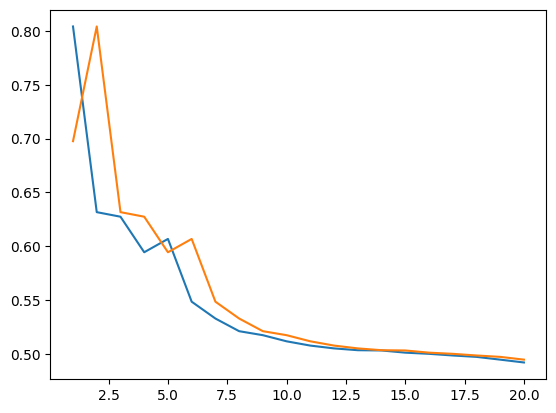

In [109]:

import matplotlib.pyplot as plt
vy = history.history['val_loss']
ty = history.history['loss']
x = list(range(1, len(vy) + 1))  # Adjust x to represent the range of epochs


plt.plot(x, vy)
plt.plot(x, ty)
plt.show()


In [110]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_generator)
print("Train Accuracy:", train_accuracy)

# Make predictions on the train set
train_predictions = model.predict(train_generator)
y_train_pred = np.where(train_predictions > 0.5, 1, 0)  # Thresholding the predictions for binary classification

# Get true labels for the train set
true_train_labels = train_generator.classes

# Print classification report for train data
print("Classification Report (Train Data):")
print(classification_report(true_train_labels, y_train_pred))

# Print accuracy for train data
accuracy_train = accuracy_score(true_train_labels, y_train_pred)
print("Accuracy (Train Data):", accuracy_train)

# Calculate confusion matrix for train data
conf_matrix_train = confusion_matrix(true_train_labels, y_train_pred)

# Calculate true positives, false negatives, true negatives, and false positives for train data
tp_train = conf_matrix_train[1, 1]
fn_train = conf_matrix_train[1, 0]
tn_train = conf_matrix_train[0, 0]
fp_train = conf_matrix_train[0, 1]

# Calculate sensitivity (true positive rate) and specificity (true negative rate) for train data
sensitivity_train = tp_train / (tp_train + fn_train)
specificity_train = tn_train / (tn_train + fp_train)

# Print sensitivity and specificity for train data
print("Sensitivity (Train Data):", sensitivity_train)
print("Specificity (Train Data):", specificity_train)


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("\nTest Accuracy:", test_accuracy)

# Make predictions on the test set
test_predictions = model.predict(test_generator)
y_test_pred = np.where(test_predictions > 0.5, 1, 0)  # Thresholding the predictions for binary classification

# Get true labels for the test set
true_test_labels = test_generator.classes

# Print classification report for test data
print("Classification Report (Test Data):")
print(classification_report(true_test_labels, y_test_pred))

# Print accuracy for test data
accuracy_test = accuracy_score(true_test_labels, y_test_pred)
print("Accuracy (Test Data):", accuracy_test)

# Calculate confusion matrix for test data
conf_matrix_test = confusion_matrix(true_test_labels, y_test_pred)

# Calculate true positives, false negatives, true negatives, and false positives for test data
tp_test = conf_matrix_test[1, 1]
fn_test = conf_matrix_test[1, 0]
tn_test = conf_matrix_test[0, 0]
fp_test = conf_matrix_test[0, 1]

# Calculate sensitivity (true positive rate) and specificity (true negative rate) for test data
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

# Print sensitivity and specificity for test data
print("Sensitivity (Test Data):", sensitivity_test)
print("Specificity (Test Data):", specificity_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.7975 - loss: 0.4921
Train Accuracy: 0.7975000143051147
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classification Report (Train Data):
              precision    recall  f1-score   support

           0       0.88      0.69      0.77       200
           1       0.74      0.91      0.82       200

    accuracy                           0.80       400
   macro avg       0.81      0.80      0.80       400
weighted avg       0.81      0.80      0.80       400

Accuracy (Train Data): 0.7975
Sensitivity (Train Data): 0.905
Specificity (Train Data): 0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step - accuracy: 0.7800 - loss: 0.4894

Test Accuracy: 0.7799999713897705
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.87      0.66      0.75        50
           1       0.73      0.90      0.80        50

    accuracy                           0.78       100
   

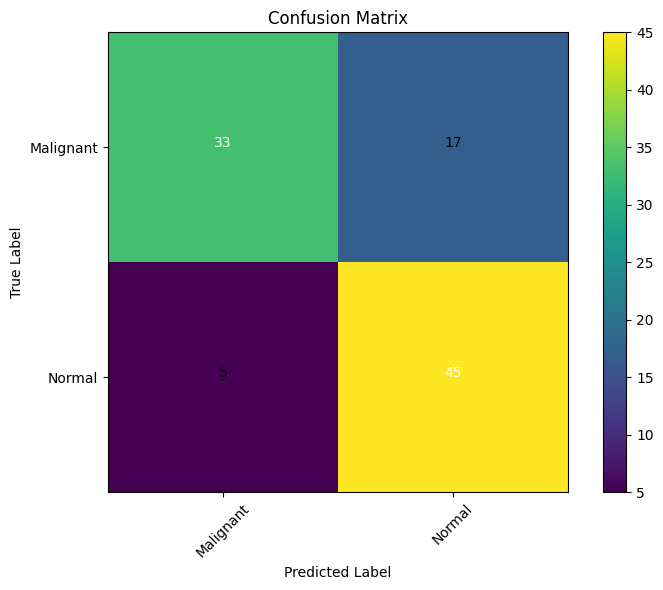

In [111]:
from sklearn.metrics import confusion_matrix as cm

# Define classes
classes = ['Malignant', 'Normal']

# Compute confusion matrix
conf_matrix = cm(true_test_labels, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [102]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the model architecture
def create_model(input_shape):
    model = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Create an instance of the model
model = create_model(input_shape=(img_height, img_width, 3))

# Print the model summary
model.summary()

# Fit the model
history = model.fit(
    train_generator, 
    epochs=20, 
    batch_size=64, 
    validation_data=test_generator, 
    verbose=2
)  

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_142"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_426 (Conv2D)             │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_426               │ (None, 64, 64, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_427 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_427               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_428 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_428               │ (None, 16, 16, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_142 (Flatten)           │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_284 (Dense)               │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_285 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,705 (16.36 MB)

 Trainable params: 4,288,257 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
1/1 - 57s - 57s/step - accuracy: 0.4175 - loss: 1.4004 - val_accuracy: 0.8000 - val_loss: 0.6969
Epoch 2/20
1/1 - 16s - 16s/step - accuracy: 0.6150 - loss: 4.1069 - val_accuracy: 0.7900 - val_loss: 1.3019
Epoch 3/20
1/1 - 14s - 14s/step - accuracy: 0.7200 - loss: 17.6766 - val_accuracy: 0.7900 - val_loss: 1.1151
Epoch 4/20
1/1 - 15s - 15s/step - accuracy: 0.7350 - loss: 4.7518 - val_accuracy: 0.7900 - val_loss: 0.7341
Epoch 5/20
1/1 - 14s - 14s/step - accuracy: 0.7925 - loss: 0.9329 - val_accuracy: 0.7800 - val_loss: 0.4918
Epoch 6/20
1/1 - 14s - 14s/step - accuracy: 0.7650 - loss: 0.9465 - val_accuracy: 0.7300 - val_loss: 0.4286
Epoch 7/20
1/1 - 14s - 14s/step - accuracy: 0.7600 - loss: 0.6703 - val_accuracy: 0.7300 - val_loss: 0.4254
Epoch 8/20
1/1 - 15s - 15s/step - accuracy: 0.7675 - loss: 0.5123 - val_accuracy: 0.7600 - val_loss: 0.4361
Epoch 9/20
1/1 - 16s - 16s/step - accuracy: 0.7450 - loss: 0.4645 - val_accuracy: 0.7500 - val_loss: 0.4443
Epoch 10/20
1/1 - 13s - 13s

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_generator)
print("Train Accuracy:", train_accuracy)

# Make predictions on the train set
train_predictions = model.predict(train_generator)
y_train_pred = np.where(train_predictions > 0.5, 1, 0)  # Thresholding the predictions for binary classification

# Get true labels for the train set
true_train_labels = train_generator.classes

# Print classification report for train data
print("Classification Report (Train Data):")
print(classification_report(true_train_labels, y_train_pred))

# Print accuracy for train data
accuracy_train = accuracy_score(true_train_labels, y_train_pred)
print("Accuracy (Train Data):", accuracy_train)

# Calculate confusion matrix for train data
conf_matrix_train = confusion_matrix(true_train_labels, y_train_pred)

# Calculate true positives, false negatives, true negatives, and false positives for train data
tp_train = conf_matrix_train[1, 1]
fn_train = conf_matrix_train[1, 0]
tn_train = conf_matrix_train[0, 0]
fp_train = conf_matrix_train[0, 1]

# Calculate sensitivity (true positive rate) and specificity (true negative rate) for train data
sensitivity_train = tp_train / (tp_train + fn_train)
specificity_train = tn_train / (tn_train + fp_train)

# Print sensitivity and specificity for train data
print("Sensitivity (Train Data):", sensitivity_train)
print("Specificity (Train Data):", specificity_train)


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("\nTest Accuracy:", test_accuracy)

# Make predictions on the test set
test_predictions = model.predict(test_generator)
y_test_pred = np.where(test_predictions > 0.5, 1, 0)  # Thresholding the predictions for binary classification

# Get true labels for the test set
true_test_labels = test_generator.classes

# Print classification report for test data
print("Classification Report (Test Data):")
print(classification_report(true_test_labels, y_test_pred))

# Print accuracy for test data
accuracy_test = accuracy_score(true_test_labels, y_test_pred)
print("Accuracy (Test Data):", accuracy_test)

# Calculate confusion matrix for test data
conf_matrix_test = confusion_matrix(true_test_labels, y_test_pred)

# Calculate true positives, false negatives, true negatives, and false positives for test data
tp_test = conf_matrix_test[1, 1]
fn_test = conf_matrix_test[1, 0]
tn_test = conf_matrix_test[0, 0]
fp_test = conf_matrix_test[0, 1]

# Calculate sensitivity (true positive rate) and specificity (true negative rate) for test data
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

# Print sensitivity and specificity for test data
print("Sensitivity (Test Data):", sensitivity_test)
print("Specificity (Test Data):", specificity_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.6725 - loss: 0.7832
Train Accuracy: 0.6725000143051147
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Classification Report (Train Data):
              precision    recall  f1-score   support

           0       0.51      0.48      0.49       200
           1       0.51      0.54      0.52       200

    accuracy                           0.51       400
   macro avg       0.51      0.51      0.51       400
weighted avg       0.51      0.51      0.51       400

Accuracy (Train Data): 0.5075
Sensitivity (Train Data): 0.535
Specificity (Train Data): 0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step - accuracy: 0.7000 - loss: 0.6184

Test Accuracy: 0.699999988079071
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.46      0.46      0.46        50
           1       0.46      0.46      0.46        50

    accuracy                           0.46       100
   ma